In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from loader import ThumbnailDataset
import pandas as pd
from matplotlib.colors import LogNorm
import umap
from scipy.stats import pearsonr

In [5]:
name = 'mrbeast'
parent_dir = f'cruft/{name}_dash/raw'
files = sorted([parent_dir + '/' + f for f in os.listdir(parent_dir)], key=lambda x: int(x.split('_')[-1].split('.')[0]))
for f in files[:10]:
    print(f)

cruft/mrbeast_dash/raw/sae_activations_0.pt
cruft/mrbeast_dash/raw/sae_activations_256.pt
cruft/mrbeast_dash/raw/sae_activations_512.pt
cruft/mrbeast_dash/raw/sae_activations_768.pt


In [6]:
cutoff = 387 # around the 100,000 subscriber video, 9th July 2016
# cutoff = 9000
path = os.path.join('channel', name)
dataset = ThumbnailDataset(path, data_types=['numeric', 'thumbnail'], device='cpu')

views = dataset[:cutoff]['viewCount']
print(views.shape)
date = dataset[:cutoff]['publishedAt']
duration = dataset[:cutoff]['duration']

torch.Size([387])


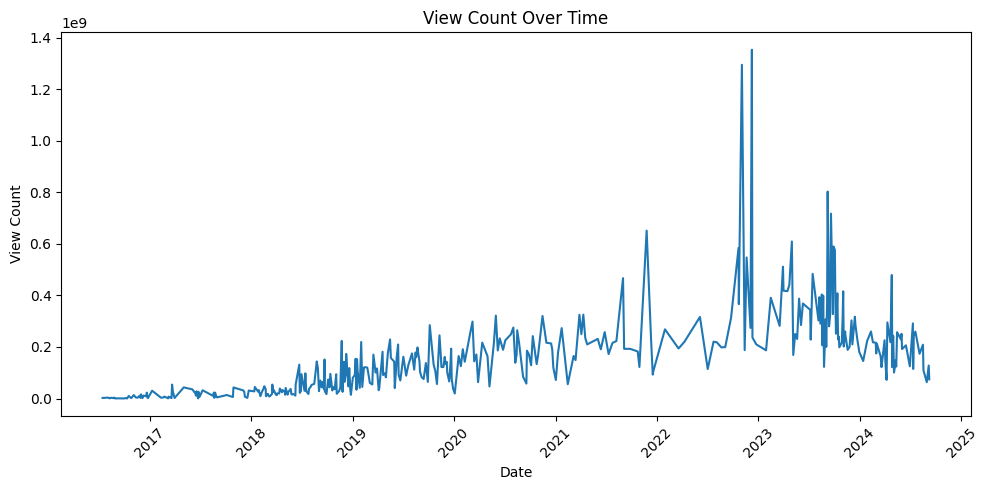

In [7]:
date = pd.to_datetime(dataset[:cutoff]['publishedAt'], unit='s')
plt.figure(figsize=(10, 5))
plt.plot(date, views)
plt.xlabel('Date')
plt.ylabel('View Count')
plt.title('View Count Over Time')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [8]:
stack = None

for f in files:
    data = torch.load(f).T
    if stack is None:
        stack = data
    else:
        stack = torch.cat((stack, data))

print(stack.shape)
stack = stack.cpu()
stack = stack[:cutoff]
print(stack.shape)

short_mask = duration > 61

views = views[short_mask]
stack = stack[short_mask]

print(stack.shape)

torch.Size([814, 65536])
torch.Size([387, 65536])
torch.Size([329, 65536])


In [9]:
binstack = stack > 0.05
binstacksum = binstack.sum(dim=0)
means = torch.zeros(stack.shape[1])

for i in range(stack.shape[1]):
    if binstacksum[i] > 10:
        # active_videos = binstack[:, i] > 0
        _, active_videos = torch.topk(stack[:, i], 10)
        active_vid_views = views[active_videos]

        mean_views = active_vid_views.mean()

        means[i] = mean_views

n_nonzero = (means > 0).sum()
print(n_nonzero)

# print topk as scientific notation 

topk = torch.topk(means, 10).values

torch.set_printoptions(sci_mode=True)
print(topk)

tensor(159)
tensor([2.2737e+08, 2.2078e+08, 2.2048e+08, 2.1761e+08, 2.1102e+08, 2.0803e+08,
        2.0729e+08, 2.0208e+08, 1.9633e+08, 1.9532e+08])


In [13]:
# choose 10 view counts at random
rand_means = []
for i in range(500):
    rand_idx = torch.randint(0, views.shape[0], (10,))

    rand_means.append(views[rand_idx].mean())

print(f'{np.mean(rand_means):.2e} +- {np.std(rand_means):.2e} --- {np.mean(rand_means) + 2 * np.std(rand_means):.2e}/{np.mean(rand_means) - 2 * np.std(rand_means):.2e}')


1.16e+08 +- 3.22e+07 --- 1.80e+08/5.15e+07


(array([0., 0., 2., 0., 3., 1., 5., 5., 7., 2., 4., 2., 5., 3., 3., 3., 4.,
        7., 8., 2., 5., 6., 9., 7., 5., 4., 3., 4., 5., 3., 4., 3., 3., 4.,
        0., 2., 3., 3., 2., 1., 4., 5., 1., 1., 2., 0., 3., 0., 1., 0.]),
 array([1.00000000e+00, 4.71223550e+06, 9.42447000e+06, 1.41367050e+07,
        1.88489400e+07, 2.35611740e+07, 2.82734080e+07, 3.29856420e+07,
        3.76978760e+07, 4.24101120e+07, 4.71223480e+07, 5.18345800e+07,
        5.65468160e+07, 6.12590520e+07, 6.59712840e+07, 7.06835200e+07,
        7.53957520e+07, 8.01079920e+07, 8.48202240e+07, 8.95324560e+07,
        9.42446960e+07, 9.89569280e+07, 1.03669160e+08, 1.08381392e+08,
        1.13093632e+08, 1.17805864e+08, 1.22518096e+08, 1.27230336e+08,
        1.31942568e+08, 1.36654800e+08, 1.41367040e+08, 1.46079280e+08,
        1.50791504e+08, 1.55503744e+08, 1.60215984e+08, 1.64928208e+08,
        1.69640448e+08, 1.74352672e+08, 1.79064912e+08, 1.83777152e+08,
        1.88489376e+08, 1.93201616e+08, 1.97913856e+08

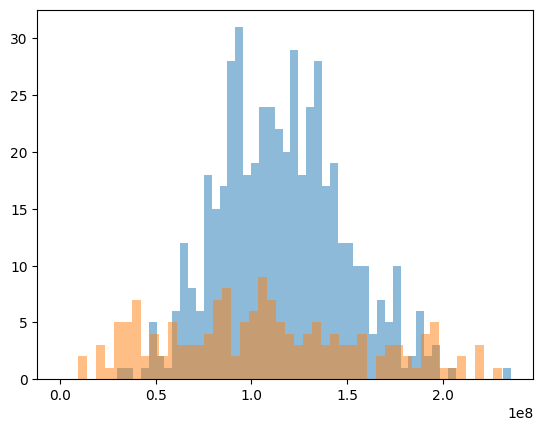

In [16]:
up_to = max(np.max(rand_means).item(), means.max().item()) + 1
plt.hist(rand_means, alpha=0.5, bins=50)
plt.hist(means, alpha=0.5, bins=50, range=(1, up_to))
